# Cracion y Evaluacion de Modelos
Prueba de modelo para clasificar las posturas de yoga establecidas

## Librerias utilizadas

In [1]:
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls
%mkdir data
!ls

gdrive	sample_data
data  gdrive  sample_data


## Carga de dataset

In [4]:
import shutil

shutil.copy("/content/gdrive/MyDrive/Colab Notebooks/SIS330/Correcion de Poses/model/v1/train_data.csv","/content/data/train.csv")
shutil.copy("/content/gdrive/MyDrive/Colab Notebooks/SIS330/Correcion de Poses/model/v1/test_data.csv","/content/data/test.csv")

'/content/data/test.csv'

## Funcion softmax y funcion de evaluacion

In [5]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def evaluate(x):
    model.eval()
    y_pred = model(x)
    y_probas = softmax(y_pred)
    return torch.argmax(y_probas, axis=1)

## Procesamiento y Normalizacion de datos para el Modelo

In [6]:
# clase Dataset, hereda de la clase `torch.utils.data.Dataset`
class Dataset(torch.utils.data.Dataset):
    # constructor
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float().cuda()
        self.Y = torch.from_numpy(Y).long().cuda()
    # devolvemos el número de datos en el dataset
    def __len__(self):
        return len(self.X)
    # devolvemos el elemento `ix` del dataset
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

In [7]:
def load_csv(csv_path):
    # Normalizacion de datos de los dataset creados
    df = pd.read_csv(csv_path)
    df.drop(['filename'],axis=1, inplace=True)
    classes = df.pop('class_name').unique()
    y = df.pop('class_no')
    
    X = df.astype('float64')
    # X = np.array([int(e) for e in X])
    X = df.to_numpy()
    y = np.array([int(e) for e in y])
    y = np.squeeze(y)
    # y = keras.utils.to_categorical(y)
    
    return X, y, classes

In [8]:
X, Y, class_names = load_csv('/content/data/train.csv')
trainPorcen = int(len(X)/100*80)
testPorcen = int(len(Y)/100*20)

# Train
X_train = X[:trainPorcen, :34]
y_train = Y[:trainPorcen]
print('Configuracion para el train')
print(len(X_train), len(y_train))
print(X_train.shape, y_train.shape)
# print(X_train[:2])
# print(y_train)

X_test = X[trainPorcen:trainPorcen + testPorcen, :34]
y_test = Y[trainPorcen:trainPorcen + testPorcen]
print('Configuracion para el test')
print(len(X_test), len(y_test))
print(X_test.shape, y_test.shape)

# Validate
X_val, y_val, class_names = load_csv('/content/data/test.csv')
print('Configuracion para el validate')
print(len(X_val), len(y_val))
print(X_val.shape, y_val.shape)

Configuracion para el train
1708 1708
(1708, 34) (1708,)
Configuracion para el test
427 427
(427, 34) (427,)
Configuracion para el validate
510 510
(510, 34) (510,)


In [9]:
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
dataset = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=10, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=10, shuffle=False)
}

len(dataset['train']), len(dataset['val'])
imgs, labels = next(iter(dataloader['train']))
print(imgs.shape)
# print(dataloader['train'])

torch.Size([10, 34])


## Modelo, Reguladores y Optimizadores



### MLP Perceptrón Multicapa (Multi Layer Perceptron)

In [10]:
def build_model(D_in=34, H=12, D_out=5):
    model = torch.nn.Sequential(
      torch.nn.Linear(D_in, H),
      torch.nn.ReLU(),
      torch.nn.Linear(H, H),
      torch.nn.ReLU(),
      torch.nn.Linear(H, D_out),
    ).cuda()
    # print(model.type)
    return model

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def fit(model, dataloader, epochs=100, log_each=10, weight_decay=0):
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            # print(x_b)
            y_pred = model(x_b)
            # print(y_pred, y_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
        
    return {'epoch': list(range(1, epochs+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [12]:
model = build_model()
hist = fit(model, dataloader)

Epoch 10/100 loss 1.40084 acc 0.41433 val_loss 1.44634 val_acc 0.31765
Epoch 20/100 loss 1.40000 acc 0.41447 val_loss 1.43752 val_acc 0.31765
Epoch 30/100 loss 1.40032 acc 0.41447 val_loss 1.42253 val_acc 0.31765
Epoch 40/100 loss 1.39973 acc 0.41462 val_loss 1.43354 val_acc 0.31765
Epoch 50/100 loss 1.39944 acc 0.41462 val_loss 1.45854 val_acc 0.31765
Epoch 60/100 loss 1.39897 acc 0.41462 val_loss 1.42788 val_acc 0.31765
Epoch 70/100 loss 1.39829 acc 0.41433 val_loss 1.41925 val_acc 0.31765
Epoch 80/100 loss 1.39947 acc 0.41404 val_loss 1.42026 val_acc 0.31765
Epoch 90/100 loss 1.39783 acc 0.41447 val_loss 1.43458 val_acc 0.31765
Epoch 100/100 loss 1.39737 acc 0.41433 val_loss 1.44374 val_acc 0.31765


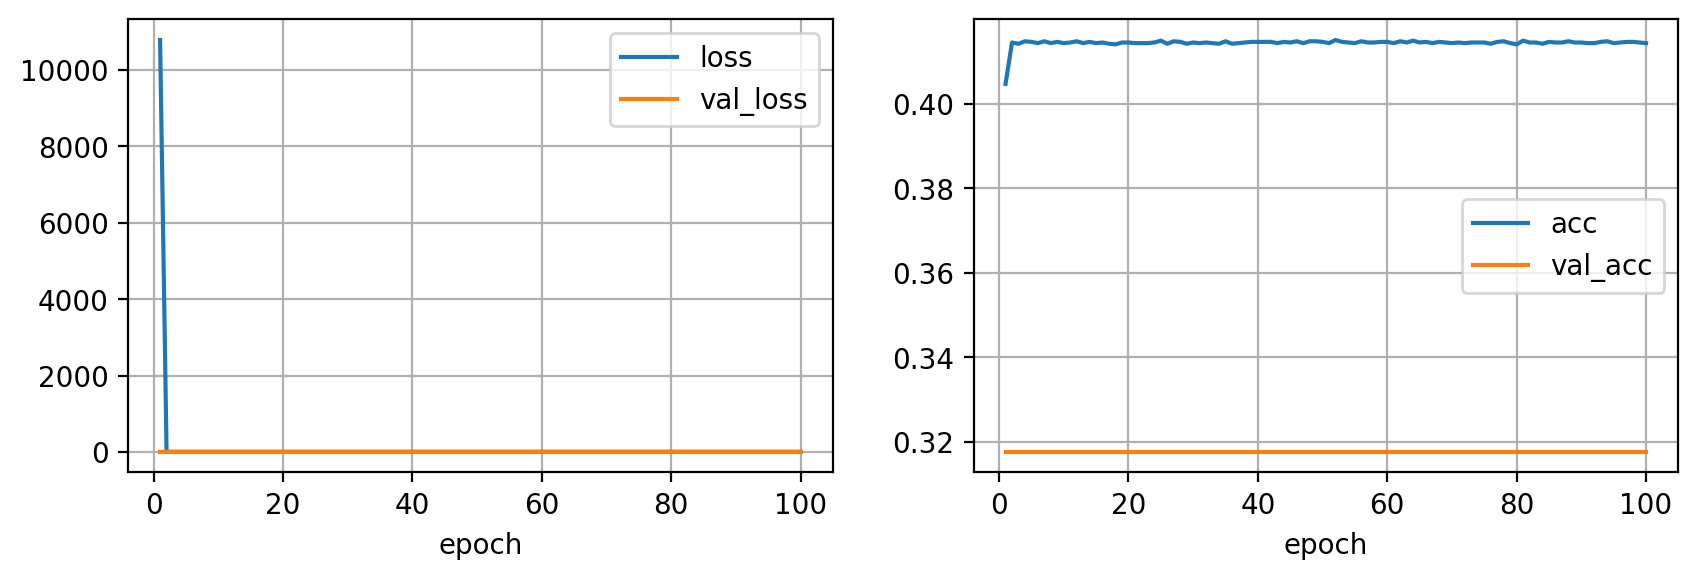

In [13]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

In [14]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.0

### Regularizacion L2

In [15]:
model = build_model()
hist = fit(model, dataloader, weight_decay=0.01)

Epoch 10/100 loss 1.40120 acc 0.41477 val_loss 1.44044 val_acc 0.31765
Epoch 20/100 loss 1.40000 acc 0.41462 val_loss 1.43385 val_acc 0.31765
Epoch 30/100 loss 1.39967 acc 0.41491 val_loss 1.44174 val_acc 0.31765
Epoch 40/100 loss 1.39890 acc 0.41404 val_loss 1.44257 val_acc 0.31765
Epoch 50/100 loss 1.39998 acc 0.41447 val_loss 1.43681 val_acc 0.31765
Epoch 60/100 loss 1.40011 acc 0.41491 val_loss 1.45386 val_acc 0.31765
Epoch 70/100 loss 1.40095 acc 0.41477 val_loss 1.42702 val_acc 0.31765
Epoch 80/100 loss 1.39941 acc 0.41462 val_loss 1.42319 val_acc 0.31765
Epoch 90/100 loss 1.40004 acc 0.41462 val_loss 1.43432 val_acc 0.31765
Epoch 100/100 loss 1.40019 acc 0.41447 val_loss 1.43534 val_acc 0.31765


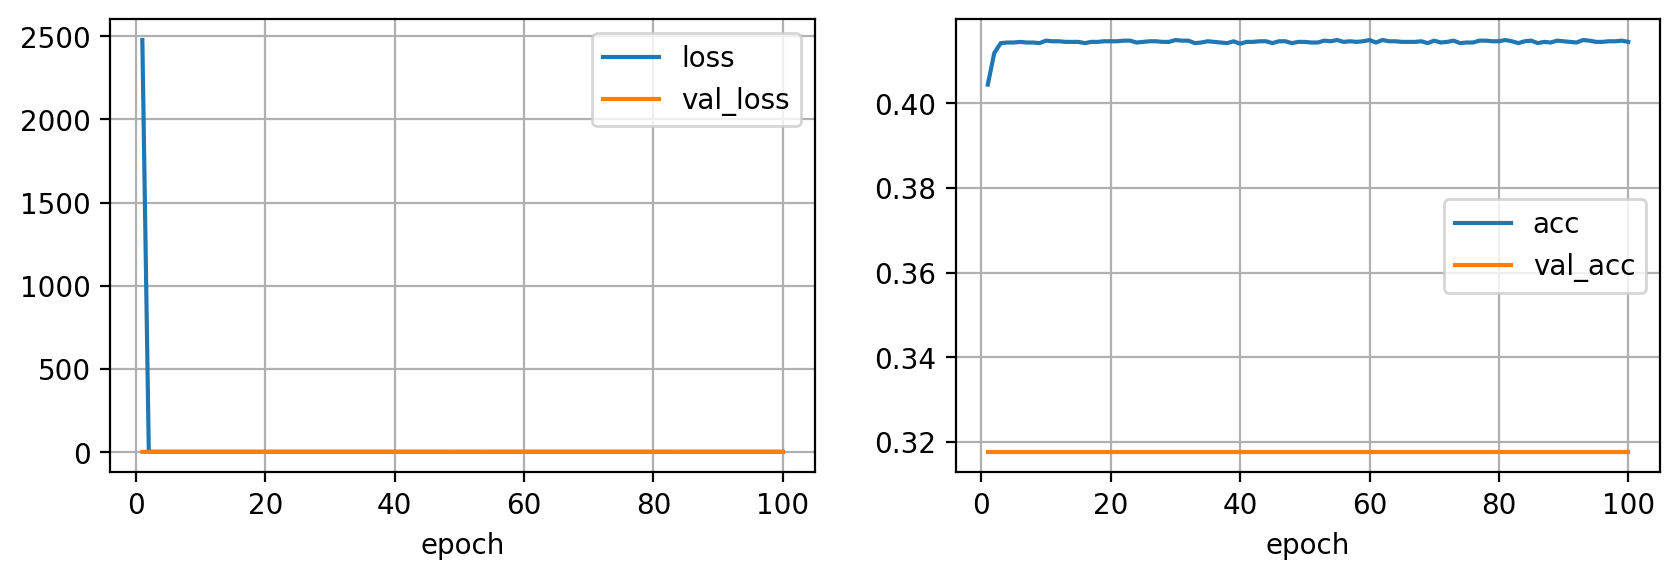

In [16]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

In [17]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.0

### Early Stopping

In [18]:
def fit(model, dataloader, epochs=100, log_each=10, weight_decay=0, early_stopping=0, type_point=''):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), type_point +'Ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load(type_point +'Ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [19]:
model = build_model()
hist = fit(model, dataloader, early_stopping=20, type_point='early')

Mejor modelo guardado con acc 0.31765 en epoch 1
Epoch 10/100 loss 1.40254 acc 0.41447 val_loss 1.43330 val_acc 0.31765
Epoch 20/100 loss 1.40179 acc 0.41433 val_loss 1.43928 val_acc 0.31765
Entrenamiento detenido en epoch 21 por no mejorar en 20 epochs seguidas


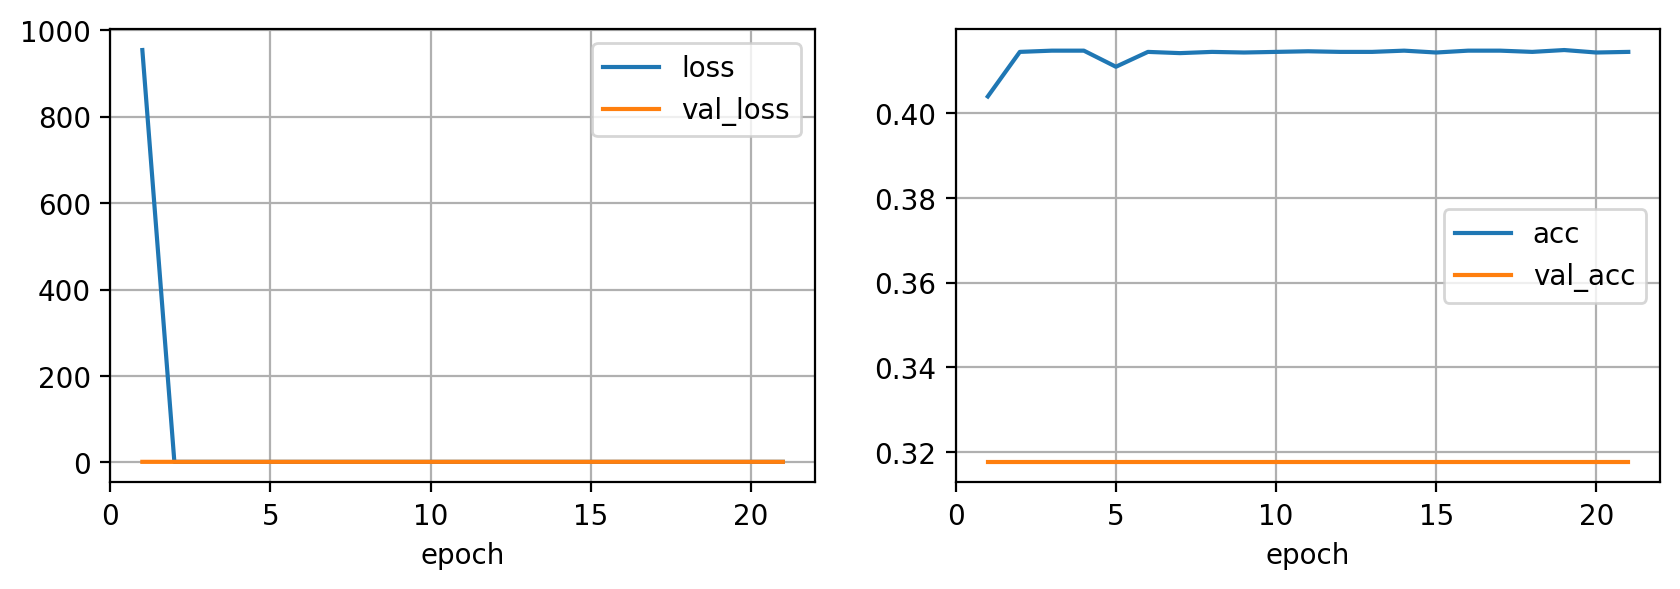

In [20]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

In [21]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.0

### Dropout

In [22]:
def build_model(D_in=34, H=12, D_out=5, p=0):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, D_out)
    ).cuda()

In [23]:
model = build_model(p=0.5)
hist = fit(model, dataloader, type_point='drop')

Mejor modelo guardado con acc 0.31569 en epoch 1
Mejor modelo guardado con acc 0.31765 en epoch 2
Epoch 10/100 loss 1.39844 acc 0.41433 val_loss 1.42462 val_acc 0.31765
Epoch 20/100 loss 1.39740 acc 0.41418 val_loss 1.42836 val_acc 0.31765
Epoch 30/100 loss 1.39790 acc 0.41462 val_loss 1.43550 val_acc 0.31765
Epoch 40/100 loss 1.39837 acc 0.41433 val_loss 1.43682 val_acc 0.31765
Epoch 50/100 loss 1.39815 acc 0.41433 val_loss 1.42794 val_acc 0.31765
Epoch 60/100 loss 1.39782 acc 0.41418 val_loss 1.43230 val_acc 0.31765
Epoch 70/100 loss 1.39775 acc 0.41433 val_loss 1.42357 val_acc 0.31765
Epoch 80/100 loss 1.39663 acc 0.41418 val_loss 1.43513 val_acc 0.31765
Epoch 90/100 loss 1.39748 acc 0.41462 val_loss 1.42087 val_acc 0.31765
Epoch 100/100 loss 1.39696 acc 0.41433 val_loss 1.44277 val_acc 0.31765


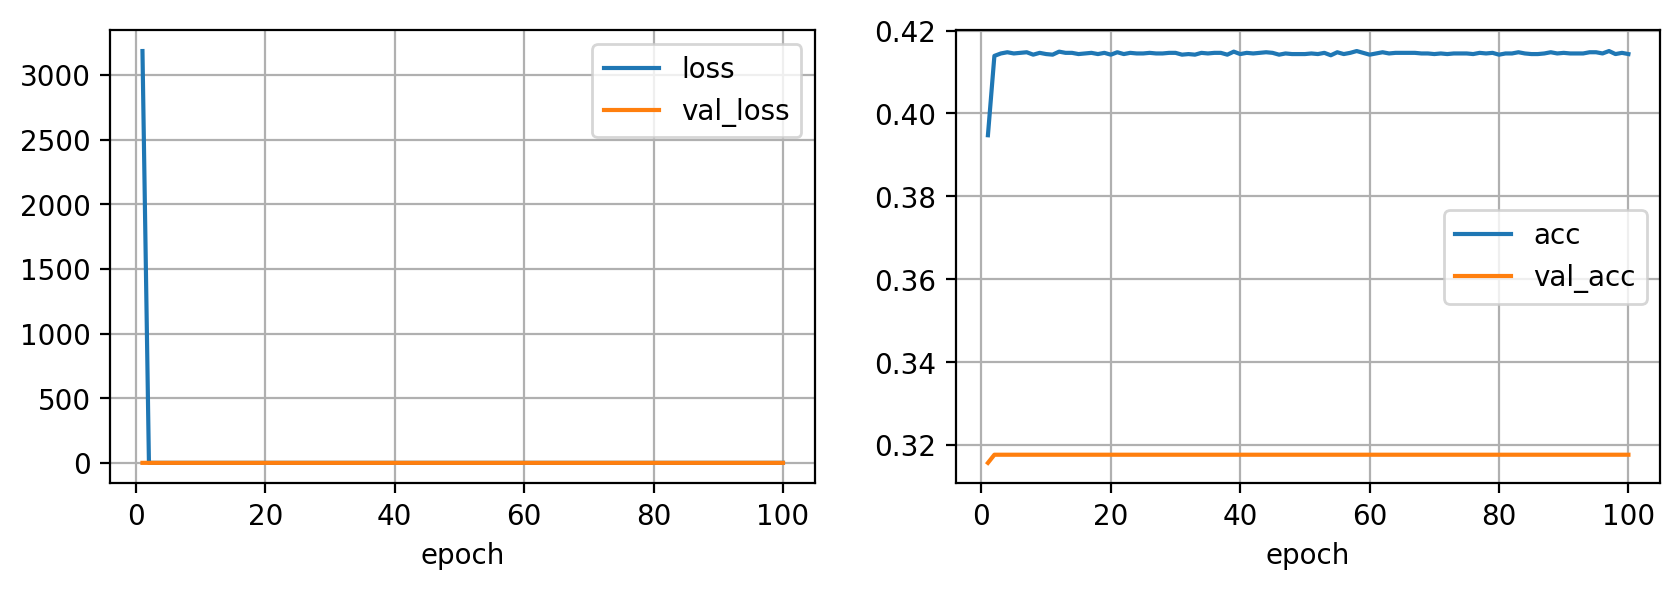

In [24]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

In [25]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())
# accuracy_score(y_test, y_pred.numpy())

0.0

### Optimizacion

In [26]:
def fit(model, dataloader, optimizer, epochs=100, log_each=10, weight_decay=0, early_stopping=0, type_point=''):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), type_point +'Ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load(type_point +'Ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

#### SGD (‘Stochastic Gradient Descent‘)

In [27]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
hist_sgd = fit(model, dataloader, optimizer, type_point='sgd')

Mejor modelo guardado con acc 0.68627 en epoch 1
Mejor modelo guardado con acc 0.76275 en epoch 4
Mejor modelo guardado con acc 0.78235 en epoch 6
Mejor modelo guardado con acc 0.80392 en epoch 8
Mejor modelo guardado con acc 0.84118 en epoch 9
Mejor modelo guardado con acc 0.89412 en epoch 10
Epoch 10/100 loss 0.35447 acc 0.91096 val_loss 0.37321 val_acc 0.89412
Mejor modelo guardado con acc 0.89608 en epoch 11
Mejor modelo guardado con acc 0.90392 en epoch 18
Epoch 20/100 loss 0.29114 acc 0.91842 val_loss 0.33218 val_acc 0.89020
Mejor modelo guardado con acc 0.91765 en epoch 28
Epoch 30/100 loss 0.19988 acc 0.94795 val_loss 0.31499 val_acc 0.90784
Mejor modelo guardado con acc 0.92157 en epoch 37
Mejor modelo guardado con acc 0.92353 en epoch 40
Epoch 40/100 loss 0.26047 acc 0.94839 val_loss 0.23514 val_acc 0.92353
Mejor modelo guardado con acc 0.92941 en epoch 42
Epoch 50/100 loss 0.12774 acc 0.96433 val_loss 0.24033 val_acc 0.90980
Mejor modelo guardado con acc 0.93922 en epoch 51


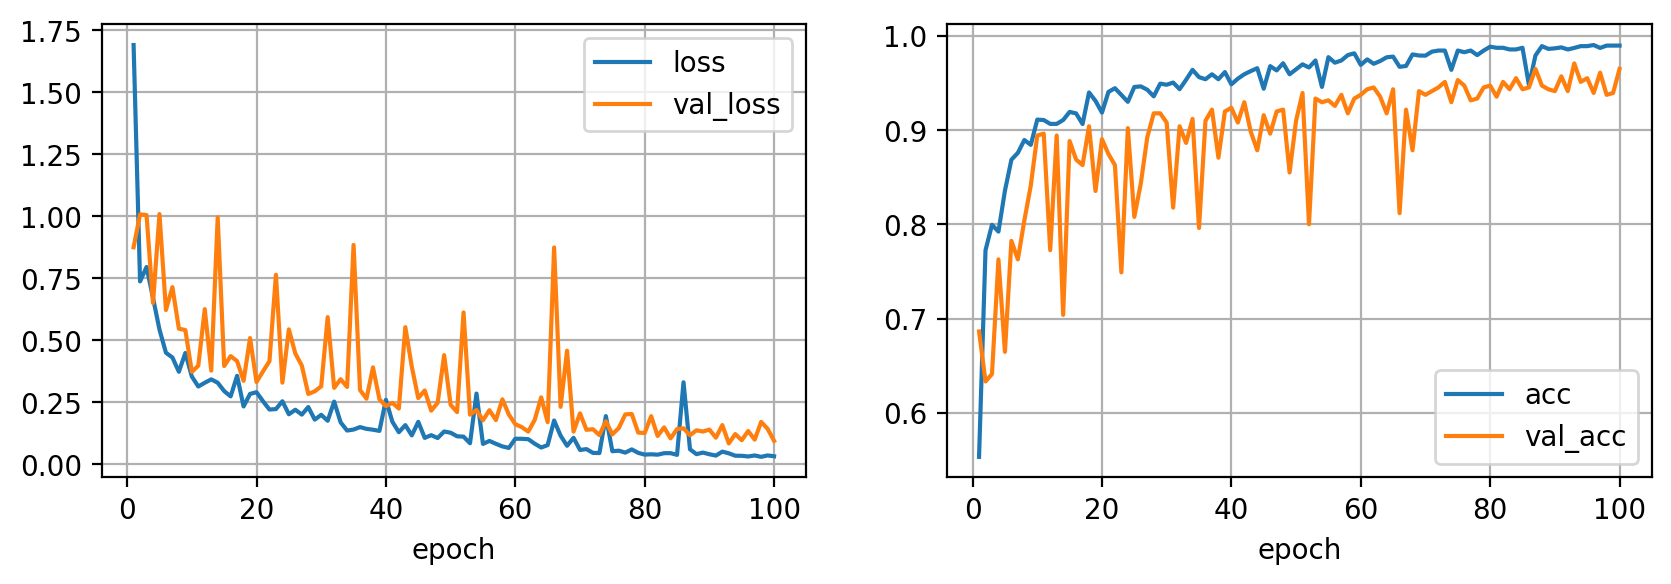

In [28]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist_sgd).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist_sgd).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

In [29]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.9297423887587822

#### SGD Momentum

In [30]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_momentum = fit(model, dataloader, optimizer, type_point='moment')

Mejor modelo guardado con acc 0.31765 en epoch 1
Epoch 10/100 loss 1.40329 acc 0.41447 val_loss 1.44261 val_acc 0.31765
Epoch 20/100 loss 1.39660 acc 0.41477 val_loss 1.43546 val_acc 0.31765
Epoch 30/100 loss 1.39584 acc 0.41433 val_loss 1.43510 val_acc 0.31765
Epoch 40/100 loss 1.39524 acc 0.41477 val_loss 1.43332 val_acc 0.31765
Epoch 50/100 loss 1.39514 acc 0.41477 val_loss 1.43527 val_acc 0.31765
Epoch 60/100 loss 1.39536 acc 0.41462 val_loss 1.43323 val_acc 0.31765
Epoch 70/100 loss 1.39535 acc 0.41462 val_loss 1.43331 val_acc 0.31765
Epoch 80/100 loss 1.39561 acc 0.41418 val_loss 1.43510 val_acc 0.31765
Epoch 90/100 loss 1.39521 acc 0.41477 val_loss 1.43488 val_acc 0.31765
Epoch 100/100 loss 1.39540 acc 0.41447 val_loss 1.43401 val_acc 0.31765


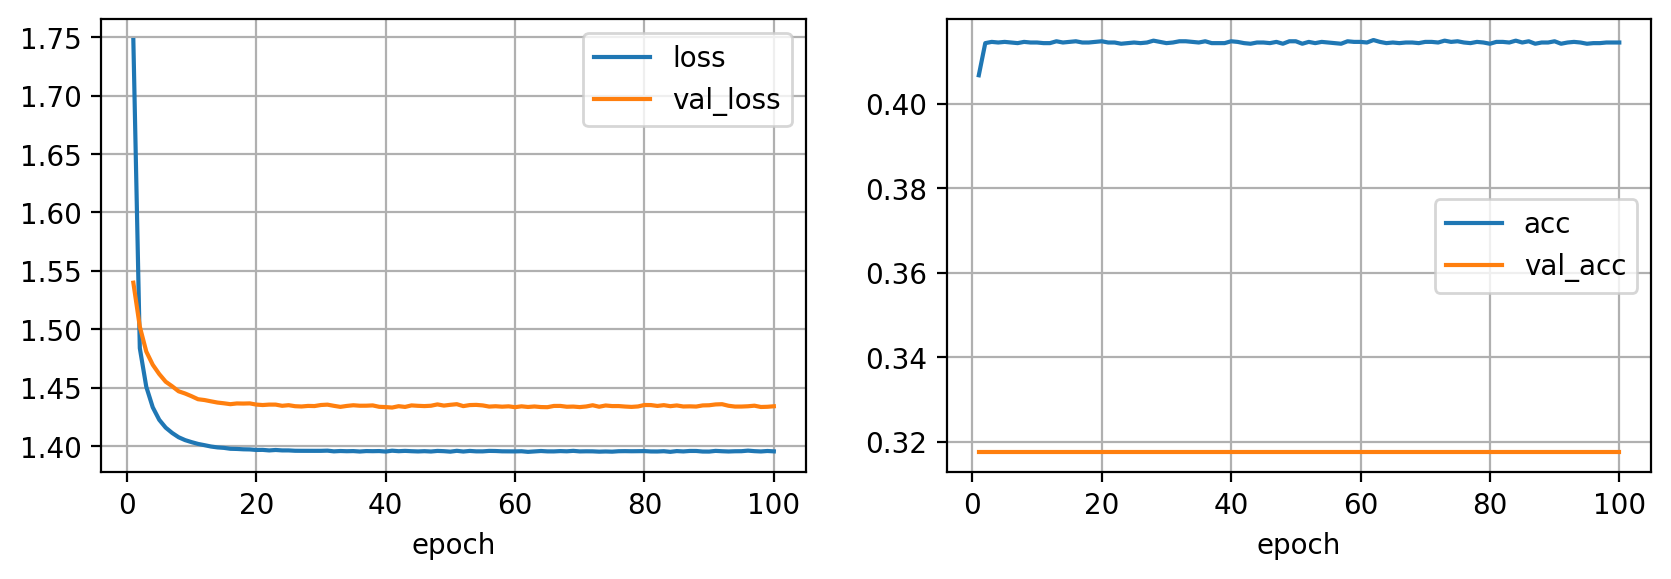

In [31]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist_momentum).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist_momentum).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

In [32]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.0

#### RMSprop (Root Mean Square Propagation)

In [33]:
model = build_model()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
hist_rms = fit(model, dataloader, optimizer, type_point='rms')

Mejor modelo guardado con acc 0.51765 en epoch 1
Mejor modelo guardado con acc 0.72941 en epoch 2
Mejor modelo guardado con acc 0.86667 en epoch 5
Mejor modelo guardado con acc 0.87647 en epoch 6
Mejor modelo guardado con acc 0.88824 en epoch 7
Mejor modelo guardado con acc 0.89608 en epoch 8
Mejor modelo guardado con acc 0.91569 en epoch 9
Epoch 10/100 loss 0.18581 acc 0.93977 val_loss 0.49314 val_acc 0.84902
Mejor modelo guardado con acc 0.92157 en epoch 11
Mejor modelo guardado con acc 0.92549 en epoch 14
Mejor modelo guardado con acc 0.94510 en epoch 17
Epoch 20/100 loss 0.08991 acc 0.96769 val_loss 0.53044 val_acc 0.88627
Mejor modelo guardado con acc 0.95490 en epoch 23
Mejor modelo guardado con acc 0.96078 en epoch 24
Mejor modelo guardado con acc 0.96667 en epoch 28
Epoch 30/100 loss 0.06652 acc 0.97602 val_loss 0.25265 val_acc 0.94706
Mejor modelo guardado con acc 0.96863 en epoch 39
Epoch 40/100 loss 0.09440 acc 0.97895 val_loss 0.28869 val_acc 0.94314
Mejor modelo guardado c

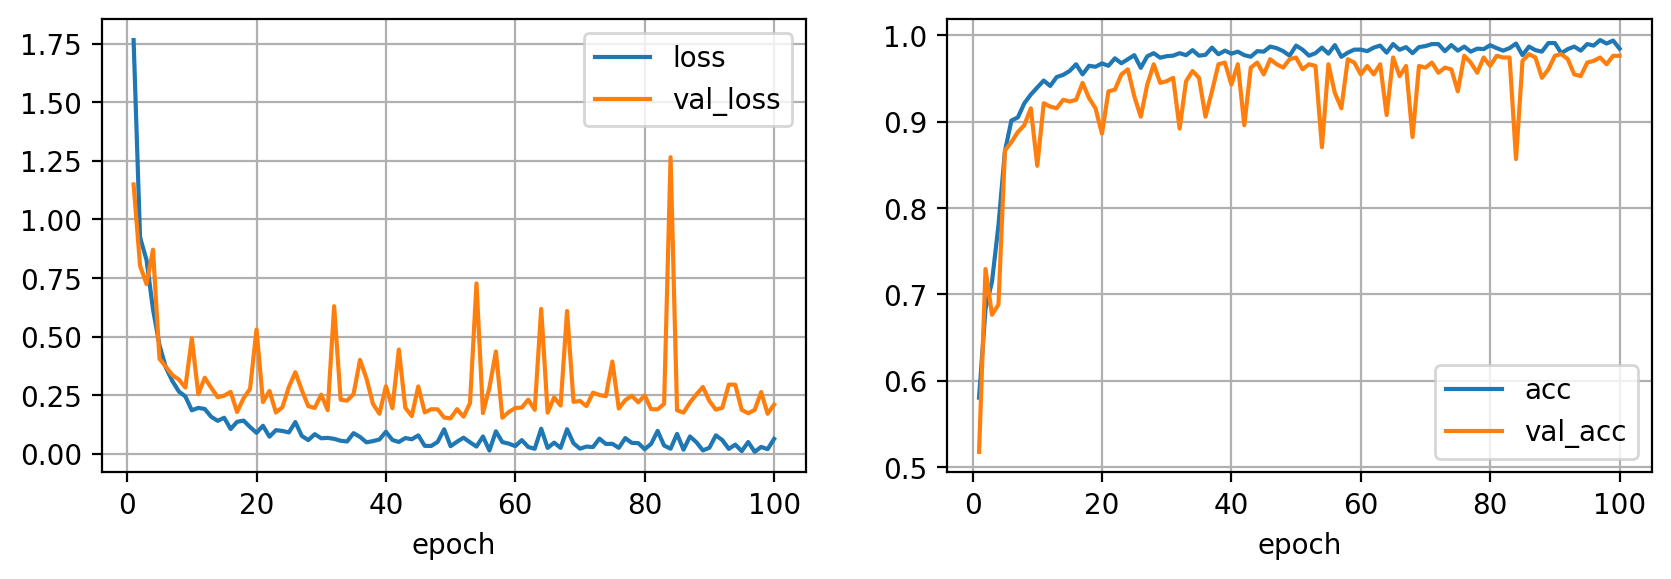

In [34]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist_rms).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist_rms).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

In [35]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.9578454332552693

#### Adam (Adaptive moment estimation)

In [36]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
hist_adam = fit(model, dataloader, optimizer, type_point='adam')

Mejor modelo guardado con acc 0.70196 en epoch 1
Mejor modelo guardado con acc 0.75882 en epoch 2
Mejor modelo guardado con acc 0.83333 en epoch 3
Mejor modelo guardado con acc 0.86471 en epoch 4
Mejor modelo guardado con acc 0.91176 en epoch 6
Epoch 10/100 loss 0.13628 acc 0.96652 val_loss 0.51562 val_acc 0.89020
Mejor modelo guardado con acc 0.91961 en epoch 11
Mejor modelo guardado con acc 0.94314 en epoch 12
Mejor modelo guardado con acc 0.95098 en epoch 14
Mejor modelo guardado con acc 0.95686 en epoch 17
Epoch 20/100 loss 0.07205 acc 0.97997 val_loss 0.20552 val_acc 0.93137
Mejor modelo guardado con acc 0.96667 en epoch 24
Mejor modelo guardado con acc 0.96863 en epoch 27
Epoch 30/100 loss 0.12939 acc 0.96433 val_loss 0.17178 val_acc 0.94510
Epoch 40/100 loss 0.13288 acc 0.97295 val_loss 0.21282 val_acc 0.94510
Mejor modelo guardado con acc 0.97059 en epoch 50
Epoch 50/100 loss 0.09042 acc 0.97193 val_loss 0.15871 val_acc 0.97059
Mejor modelo guardado con acc 0.97059 en epoch 53


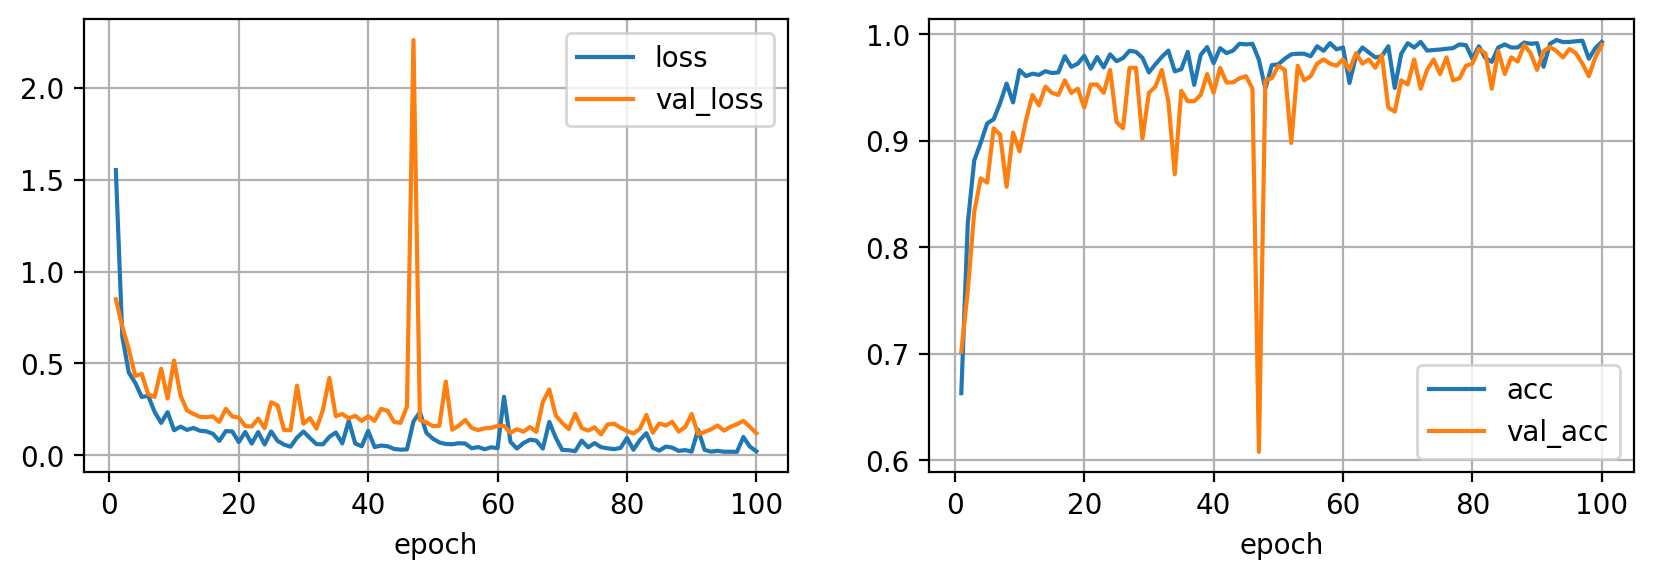

In [37]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist_adam).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist_adam).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

In [38]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.9414519906323185

#### Conclusion de Optimizadores

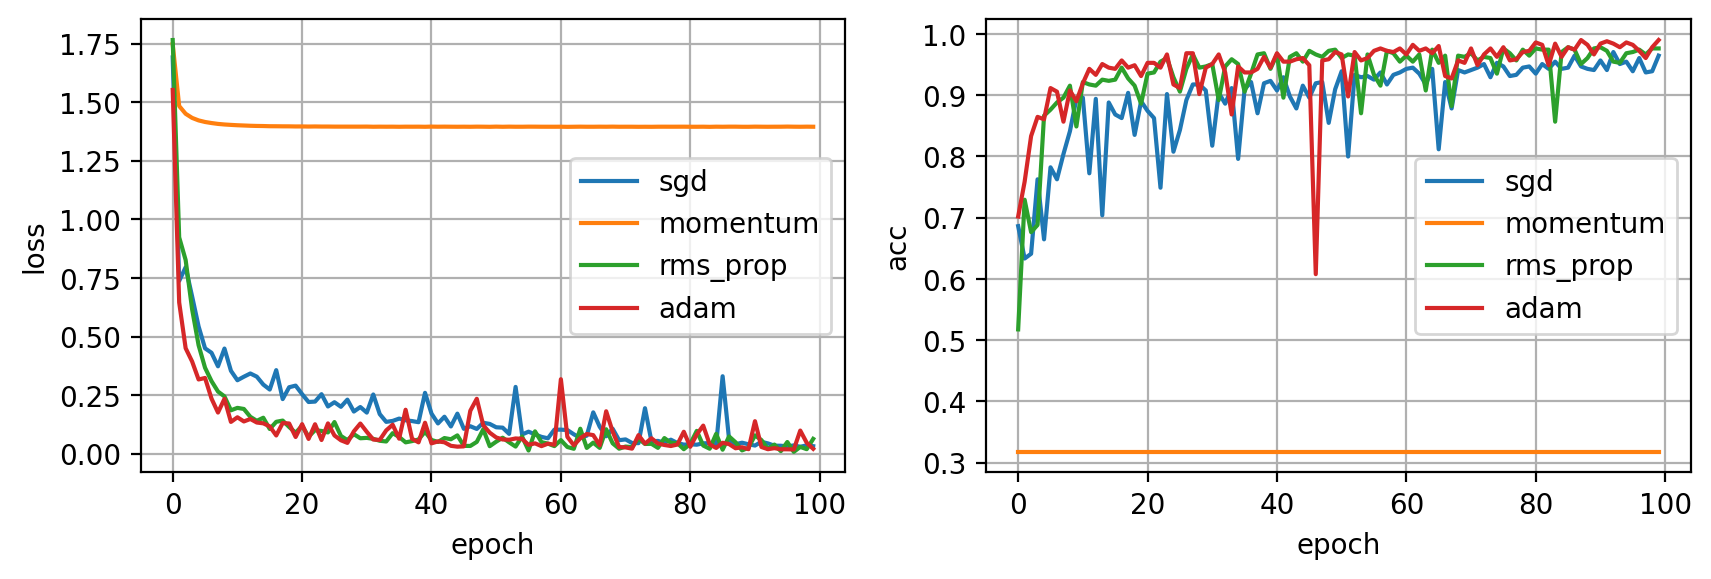

In [39]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_sgd['loss'], label="sgd")
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_rms['loss'], label="rms_prop")
ax.plot(hist_adam['loss'], label="adam")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_sgd['val_acc'], label="sgd")
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_rms['val_acc'], label="rms_prop")
ax.plot(hist_adam['val_acc'], label="adam")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

## Guardado del Modelo con ONNX

In [40]:
x = torch.rand(10, 34)
y = model.cpu()(x)

# exportamos el modelo
torch.onnx.export(model,                     # el modelo
                  x,                         # un ejemplo del input
                  "model.onnx",              # el nombre del archivo para guardar el modelo
                  export_params=True,        # guardar los pesos de la red
                  opset_version=10,          # versión de ONNX
                  do_constant_folding=True,  # optimizaciones
                  input_names = ['input'],   # nombre de los inputs
                  output_names = ['output'], # nombre de los outputs
                  dynamic_axes={'input' : {0 : 'batch_size'},    # ejes con longitud variable (para poder usar diferentes tamaños de batch)
                                'output' : {0 : 'batch_size'}})

In [ ]:
!pip install onnxruntime

In [42]:
import onnxruntime

def onnx_evaluate(model, dataloader): 
    # cargarmos el modelo
    ort_session = onnxruntime.InferenceSession(model)
    bar = tqdm(dataloader['val'])
    acc = []
    with torch.no_grad():
        for batch in bar:
            # print(batch)
            X, y = batch
            X, y = X.cpu().numpy(), y.cpu().numpy()
            # generamos los inputs
            ort_inputs = {ort_session.get_inputs()[0].name: X}
            # extraemos los outputs
            ort_outs = ort_session.run(None, ort_inputs)[0]
            acc.append((y == np.argmax(ort_outs, axis=1)).mean())
            bar.set_description(f"acc {np.mean(acc):.5f}")

In [43]:
onnx_evaluate("model.onnx", dataloader)

acc 0.99020: 100%|██████████| 51/51 [00:00<00:00, 377.67it/s]
